**Imports**

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
import scipy as sp
import scipy.optimize
from itertools import permutations
from itertools import combinations
from itertools import product
from IPython.display import clear_output

**Functions for vertices and hypergraphs**

In [ ]:
def generate_random_adjacency_tensor(k, n, prob):
    """
    Generate a random binary adjacency tensor for a hypergraph with unique edges.

    Parameters:
    k (int): The rank of the hypergraph (number of vertices in each edge).
    n (int): The number of vertices.
    prob (float): The probability for each edge to be part of the graph.

    Returns:
    ndarray: A random binary adjacency tensor of shape (n, n, ..., n).
    """
    # Create a tensor filled with zeros
    adjacency_tensor = np.zeros((n,) * k, dtype=int)

    # Generate random unique edges
    num_possible_edges = np.math.factorial(n) // (np.math.factorial(k) * np.math.factorial(n - k))
    num_edges = int(num_possible_edges * prob)

    edge_indices = list(np.arange(n))
    for _ in range(num_edges):
        np.random.shuffle(edge_indices)
        indices = tuple(edge_indices[:k])
        permuted_indices = set(permutations(indices))

        # Set values to 1 at indices that are permutations
        for idx in permuted_indices:
            adjacency_tensor[idx] = 1

    return adjacency_tensor

In [ ]:
def plot_hypergraph(adjacency_tensor, vertex_positions):
    """
    Plot a hypergraph using an adjacency tensor and vertex positions.

    Parameters:
    adjacency_tensor (ndarray): The binary adjacency tensor.
    vertex_positions (ndarray): The positions of vertices on a plane, size (2, n).

    Returns:
    None
    """
    n = vertex_positions.shape[1]

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot vertices as points
    ax.scatter(vertex_positions[0,:], vertex_positions[1,:])

    # Plot edges as transparent polygons
    for idx in np.ndindex(*adjacency_tensor.shape):
        if adjacency_tensor[idx] == 1:
            edge_points = vertex_positions[:, idx]
            edge_polygon = mpatches.Polygon(edge_points.T, closed=True, fill=True, edgecolor='b', alpha=0.2/k)
            ax.add_patch(edge_polygon)

    # Set axis limits and labels
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    # Show the plot
    plt.show()

In [ ]:
def is_clique(adjacency_tensor, x, k):
    """
    Check if the support of vector x forms a k-clique in a hypergraph.

    Parameters:
    adjacency_tensor (ndarray): The adjacency tensor of the hypergraph.
    x (ndarray): The vector representing chosen vertices.
    k (int): The rank of the hypergraph.

    Returns:
    bool: True if the support of x forms a k-clique, False otherwise.
    """
    # Find the support indices (indices where x is non-zero)
    support_indices = np.where(x != 0)[0]

    # Check if there are at least k vertices in the support
    if len(support_indices) < k:
        return False

    # Generate all combinations of k vertices from the support
    combinations_support = list(combinations(support_indices, k))

    # Check if there is an edge between all k-subsets of the support
    for subset in combinations_support:
        # Create a tuple of indices to access the hypergraph
        indices = tuple(subset)
        if adjacency_tensor[indices] != 1:
            return False

    return True

In [ ]:
def plot_fake_edges_and_final_clique(adjacency_tensor, vertex_positions, x, y, subplot=None):
    """
    Plot the fake edges in the hypergraph and the final clique using an adjacency tensor, vertex positions.

    Parameters:
    adjacency_tensor (ndarray): The binary adjacency tensor.
    vertex_positions (ndarray): The positions of vertices on a plane, size (2, n).
    x (ndarray): The vector x coding for the final clique.
    y (ndarray): The multidimensional array y representing the fake edges.
    subplot (matplotlib.axes._subplots.AxesSubplot) : The subplot to work with, if set to None then a new one is created.

    Returns:
    None
    """
    n = vertex_positions.shape[1]

    # Create a figure and axis
    if subplot == None:
      fig, ax = plt.subplots()
    else:
      fig, ax = subplot

    # Iterate through all possible indices
    for idx in np.ndindex(*adjacency_tensor.shape):
        if adjacency_tensor[idx] == 1 and all(x[i] != 0 for i in idx): # Check if all x_i are non-zero
            edge_points = vertex_positions[:, idx]
            edge_polygon = mpatches.Polygon(edge_points.T, closed=True, fill=True, edgecolor='b', facecolor='b',alpha=0.2/k)
            ax.add_patch(edge_polygon)
        elif y[idx] == 1:  # Check if the edge is coded in y
            edge_points = vertex_positions[:, idx]
            edge_polygon = mpatches.Polygon(edge_points.T, closed=True, fill=True, edgecolor='r', facecolor='r',alpha=0.2/k)
            ax.add_patch(edge_polygon)

    # Plot vertices as points
    ax.scatter(vertex_positions[0, :], vertex_positions[1, :], edgecolors='b', alpha = 0.2*(1 - x/np.max(x))) #Unchosen vertices
    ax.scatter(vertex_positions[0, :], vertex_positions[1, :], edgecolors='g', facecolors='y', alpha = 1*x/np.max(x)) #Chosen vertices


    # Set axis limits and labels
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal', adjustable='box')

    # Add a legend
    handles, labels = ax.get_legend_handles_labels()

    green_dot = Line2D([0], [0], marker='o', markeredgecolor='b', linestyle='', alpha=0.2, label='Unchosen vertices')
    orange_dot = Line2D([0], [0], marker='o', markeredgecolor='g', markerfacecolor='y', linestyle='', alpha=1, label='Vertices of the clique')

    blue_patch = mpatches.Patch(color='b', label='Edges of the original graph')
    red_patch = mpatches.Patch(color='r', label='Fake edges')

    handles = [green_dot, orange_dot, blue_patch, red_patch]

    ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5))

    # Show the plot
    plt.show()

**Miscellaneous functions**

In [ ]:
def complementary_hypergraph(adjacency_tensor):
    """
    Compute the adjacency tensor of the complementary hypergraph.

    Parameters:
    adjacency_tensor (ndarray): The adjacency tensor of the original hypergraph.

    Returns:
    ndarray: The adjacency tensor of the complementary hypergraph.
    """
    #Initialize with zeros
    complementary_adjacency_tensor = np.zeros(adjacency_tensor.shape)

    # Reverse the value
    for idx in list(product(*[range(dim) for dim in adjacency_tensor.shape])):
        if len(set(idx)) == k:
          # If all indices are different (representing an edge), flip 0s to 1s and vice versa
          complementary_adjacency_tensor[idx] = 1 - adjacency_tensor[idx]
        else:
          complementary_adjacency_tensor[idx] = 0

    return complementary_adjacency_tensor

def s_max_indices(arr, s):
    """
    Get the indices of the s maximal positive values of a symmetrical tensor, ignoring NaN and negative values and considering only one permutation of each index.

    Parameters:
    arr (ndarray): The input multidimensional array.
    s (int): The number of maximal indices to return.

    Returns:
    tuple, tuple: The indices of the s maximal values.
    """
    # Dimensions
    m = arr.shape[0] # Length of each dimension
    l = len(arr.shape) # Order of the tensor

    #Flatten the array
    flat_array = arr.reshape(-1)

    # Create an array of indices for sorting while ignoring NaN values and considering only positive values
    indices = np.transpose(np.array(np.meshgrid(*[np.arange(m)]*l,indexing='ij')),axes=np.concatenate([np.arange(1,l+1),[0]])).reshape(-1,l)
    indices_ignore_nan_only_positive = indices[np.logical_and(~np.isnan(flat_array), flat_array > 0)]

    # Convert arrays to tuples and add to a set to remove duplicates (each edge appears k! times in the tensor)
    unique_indices = set(tuple(arr) for arr in indices_ignore_nan_only_positive)

    # Convert to array and extract the corresponding values
    unique_indices_array = np.array(list(unique_indices))
    unique_values_array = arr[tuple(zip(*unique_indices))]

    # Sort the indices based on the array values while ignoring NaNs and considering only positive values
    sorted_indices = unique_indices_array[np.argsort(unique_values_array)]

    s_max_indices = sorted_indices[-min(s,len(sorted_indices)):]

    return s_max_indices

def s_minimal_indices_in_support(arr1, arr2, s):
    """
    Find the indices of the s minimal negative values of arr1 based on a mask provided by arr2 where values are not equal to 0.

    Parameters:
    arr1 (ndarray): The first input multidimensional array.
    arr2 (ndarray): The second input multidimensional array serving as a mask.
    s (int): The number of minimal indices to return.

    Returns:
    list: A list of tuples, each containing the indices of the s minimal values in arr1.
    """
    # Dimensions
    m = arr1.shape[0] # Length of each dimension
    l = len(arr1.shape) # Order of the tensor

    # Flatten both arrays
    flat_arr1 = arr1.flatten()
    flat_arr2 = arr2.flatten()

    # Create an array of indices for sorting while considering only negative values in the support of arr2
    indices = np.transpose(np.array(np.meshgrid(*[np.arange(m)]*l,indexing='ij')),axes=np.concatenate([np.arange(1,l+1),[0]])).reshape(-1,l)
    indices_on_support_only_negative = indices[np.logical_and(flat_arr2 != 0, flat_arr1 < 0)]

    # Convert arrays to tuples and add to a set to remove duplicates (each edge appears k! times in the tensor)
    unique_indices = set(tuple(arr) for arr in indices_on_support_only_negative)

    # Convert to array and extract the corresponding values
    unique_indices_array = np.array(list(unique_indices))
    unique_values_array = arr1[tuple(zip(*unique_indices))]

    # Sort the values based on arr1
    sorted_indices = unique_indices_array[np.argsort(unique_values_array)]

    # Get at most s minimal indices
    s_minimal_indices = sorted_indices[:min(s,len(sorted_indices))]

    return s_minimal_indices

**Objective function and derivatives**

Denoting the graph $G = (V, E)$, our objective function is :
\begin{align}
  \tilde{h}(x, y) := -h(x,y) :&= \sum_{e\in \overline{E}}y_e\prod_{i\in e}x_i - \sum_{e\in \overline{E}}\prod_{i\in e}x_i - \alpha \|x\|_k^k + \beta \|y\|_2^2 \\
  &= \frac{1}{k!}(\mathcal{A}(y) - \mathcal{A})x^k - \alpha \|x\|_k^k + \beta \|y\|_2^2
\end{align}

where $\mathcal{A}$ is the adjacency tensor of the graph and $\mathcal{A}(y)$ is the adjacency tensor made of the fake edges.

In [ ]:
def objective_function(Abar, x, y, k, k_factorial, alpha, beta):
    """
    Compute the objective function value using provided tensors and parameters.

    Parameters:
    Abar (ndarray): The adjacency tensor of the complementary of the graph of shape (n, n, ..., n), where n is the dimensionality.
    x (ndarray): The vector x of length n.
    y (ndarray): The multidimensional array y of shape (m, m, ..., m), where m is the dimensionality.
    k (int): The number of iterations for tensor contraction.
    k_factorial (int): The preprocessed value of k!.
    alpha (float): The parameter alpha.
    beta (float): The parameter beta.

    Returns:
    float: The computed objective function value.
    """
    # Compute (A(y) - Abar)x^k
    Ayxk = y - Abar
    for _ in range(k):
        Ayxk = np.tensordot(Ayxk, x, axes=1)

    # Compute \|x\|_k^k
    norm_xk = np.sum(x**k)

    # Compute \|y\|_2^2
    norm_y2 = np.sum(y**2)

    # Compute the final result
    return Ayxk/k_factorial - alpha * norm_xk + beta * norm_y2


The gradient with respect to $x$ is
\begin{align}
  \nabla_x \tilde{h}(x, y) &= \frac{k}{k!}(\mathcal{A}(y) - \mathcal{A})x^{k-1} - k\alpha x^{[k-1]}
\end{align}

In [ ]:
def objective_function_gradient_x(Abar, x, y, k, k_factorial, alpha):
    """
    Compute the gradient of the objective function with respect to x.

    Parameters:
    Abar (ndarray): The adjacency tensor of the complementary of the graph of shape (n, n, ..., n), where n is the dimensionality.
    x (ndarray): The vector x of length n.
    y (ndarray): The multidimensional array y of shape (m, m, ..., m), where m is the dimensionality.
    k (int): The rank of the hypergraph.
    k_factorial (int): The preprocessed value of k!.
    alpha (float): The parameter alpha.
    beta (float): The parameter beta.

    Returns:
    ndarray: The computed gradient of the objective function with respect to x.
    """
    # Compute (A(y) - Abar)x^{k-1}
    Ayxk_minus_1 = y - Abar

    for _ in range(k - 1):
        Ayxk_minus_1 = np.tensordot(Ayxk_minus_1, x, axes=1)

    # Compute the final derivative
    return Ayxk_minus_1*k/k_factorial - k * alpha * x**(k - 1)

The derivative with respect to a component of $y$ is
\begin{align}
  \frac{\partial \tilde{h}}{\partial y_e} (x, y) &= \prod_{i \in e}x_i + 2\beta y_e
\end{align}

In [ ]:
def objective_function_gradient_y(Abar, x, y, k_factorial, beta):
    """
    Compute the gradient of the objective function with respect to y.

    Parameters:
    Abar (ndarray): The adjacency tensor of the complementary of the graph of shape (n, n, ..., n), where n is the dimensionality.
    x (ndarray): The vector x of length n.
    y (ndarray): The multidimensional array y of shape (m, m, ..., m), where m is the dimensionality.
    k_factorial (int): The preprocessed value of k!.
    beta (float): The parameter beta.

    Returns:
    ndarray: The computed gradient of the objective function with respect to y.
    """
    gradient = x #Compute the product of the x_i where i is in e
    for _ in range(k - 1):
        gradient = np.tensordot(gradient, x, axes=0)

    gradient += 2*beta*y #Gradient of the regularization term
    gradient[Abar == 0] = np.nan #The value of edges that does not belong to the complement of the graph are replaced by NaN to discard them

    return gradient

**Frank Wolfe variants**

In [ ]:
def FDFW(obj_func, grad_func_x, grad_func_y, A, Abar, n, s, k_factorial, max_iter=100, tol=1e-6, plot=False, vertex_positions=None):
    """
    Perform the FDFW for a multidimensional optimization problem.

    Parameters:
    obj_func (function): The objective function to minimize.
    grad_func_x (function): The gradient function of the objective function with respect to x.
    grad_func_y (function): The gradient function of the objective function with respect to y.
    A (ndarray): The adjacency tensor of shape (n, n, ..., n).
    Abar (ndarray): The complementary adjacency tensor of the same shape as A.
    n (int): The dimensionality of the problem.
    s (int): The number of top indices to consider.
    k_factorial (int): The preprocessed value of k!.
    max_iter (int): The maximum number of iterations (default is 100).
    tol (float): The tolerance for convergence (default is 1e-6).
    plot (bool): Whether to plot the progress of the optimization scheme or not.
    vertex_positions (ndarray): The positions of vertices on a plane, size (2, n), necessary if plot is set to True.

    Returns:
    tuple: A tuple containing the optimized x, y.
    """
    # Initialization
    x = np.ones(n) / n  # Initial point for x on the simplex
    y = Abar*s/np.sum(Abar) # Initial point for y

    if plot == True:
      subplot = plt.subplots()

    for iteration in range(1,max_iter + 1):
        # Direction for x
        gradient_x = grad_func_x(x,y)

        # Find the indices of the components with the largest and smallest (only on the support of x) gradients
        max_grad_index_x = np.argmax(gradient_x)

        nonzero_indices = np.where(x != 0)[0]
        min_grad_index_x = nonzero_indices[np.argmin(gradient_x[nonzero_indices])]

        # Direction for y
        gradient_y = grad_func_y(x,y)

        greatest_indices = s_max_indices(gradient_y, s)

        y_equal_to_one_indices = np.where(y == 1)
        support = y
        support[y_equal_to_one_indices] = 0 # To discard these values
        smallest_indices_in_support = s_minimal_indices_in_support(gradient_y, support, s)

        # Define the linear approximation direction
        direction_x = np.zeros(n)
        direction_y = np.zeros(A.shape)

        dot_grad_wk = np.sum(np.multiply(gradient_x,x)) + np.nansum(np.multiply(gradient_y,y)) #Corresponds to the dot product between the gradient and w_k in the algorithm

        dot_grad_dfw = gradient_x[max_grad_index_x] + np.sum(gradient_y[greatest_indices]) - dot_grad_wk
        dot_grad_dfd = dot_grad_wk - gradient_x[min_grad_index_x] - np.sum(gradient_y[smallest_indices_in_support]) - np.sum(gradient_y[y_equal_to_one_indices])

        if dot_grad_dfw > dot_grad_dfd :
          #d_FW direction
          direction_x[max_grad_index_x] = 1

          for idx in greatest_indices:
            permuted_indices = set(permutations(idx))
            # Set values to 1 at indices that are permutations
            for permuted_idx in permuted_indices:
                direction_y[permuted_idx] = 1

          direction_x -= x
          direction_y -= y

          step_size_max = 1
        else:
          #d_FD direction
          direction_x[min_grad_index_x] = -1

          direction_y[y_equal_to_one_indices] = -1
          for idx in smallest_indices_in_support:
            permuted_indices = set(permutations(idx))
            # Set values to 1 at indices that are permutations
            for permuted_idx in permuted_indices:
                direction_y[permuted_idx] = 1

          direction_x += x
          direction_y += y

          step_size_max_x_array = np.concatenate(([
                                  abs(x[min_grad_index_x]/direction_x[min_grad_index_x])],              # To ensure that x stays above 0
                                  ((1 - x[direction_x > 0])/direction_x[direction_x > 0]).reshape(-1))) # To ensure that x stays below 1

          step_size_max_y_array = np.concatenate((
                                np.abs(y[direction_y < 0]/direction_y[direction_y < 0]).reshape(-1),  # To ensure that y stays above 0
                                ((1 - y[direction_y > 0])/direction_y[direction_y > 0]).reshape(-1))) # To ensure that y stays below 1

          if np.sum(direction_y) != 0:
            step_size_max_y_array = np.concatenate((step_size_max_y_array, [(s - np.sum(y))/np.sum(direction_y)]))  # To ensure that 1^T y stays below s

          step_size_max = 0, np.min(np.concatenate((step_size_max_x_array, step_size_max_y_array)))

        # Perform Armijo line search to find the step size
        step_size = step_size_max
        while step_size > 1e-14 and obj_func(x + step_size * direction_x, y + step_size * direction_y) < obj_func(x,y) + 0.1 * step_size * (np.sum(np.multiply(gradient_x,direction_x)) + np.nansum(np.multiply(gradient_y,direction_y))):
          step_size *= 0.8

        # Update the current point
        x_new = x + step_size * direction_x
        y_new = y + step_size * direction_y

        # Some tricks to address numerical approximation errors
        x_new[x_new < 1e-17] = 0
        y_new[y_new < 1e-17] = 0

        x_new /= np.sum(x_new)

        sum_y = np.sum(y_new)
        if sum_y > s*k_factorial :
            y_new *= s*k_factorial/sum_y

        # Check for convergence
        if np.linalg.norm(x_new - x) < tol and np.linalg.norm(y_new - y) < tol:
            break

        x = x_new
        y = y_new

        if plot == True :
          subplot[1].clear()
          plot_fake_edges_and_final_clique(A, vertex_positions, x, y, subplot)
          subplot[1].set_title("Iteration %i"%iteration)

          clear_output(wait=True) # For Google Colab
          display(subplot[0])     # For Google Colab
        else:
          print("Iteration %i finished."%iteration)

    return x, y

In [ ]:
def FDFW_only_x(obj_func, grad_func, x0, max_iter=100, tol=1e-6):
    """
    Perform the FDFW only on the x component.

    Parameters:
    obj_func (function): The objective function to minimize.
    grad_func (function): The gradient function of the objective function.
    max_iter (int): The maximum number of iterations (default is 100).
    tol (float): The tolerance for convergence (default is 1e-6).

    Returns:
    tuple: A tuple containing the optimized x.
    """
    x = x0

    for iteration in range(1,max_iter + 1):
        #Direction for x
        gradient = grad_func(x)

        # Find the indices of the components with the largest and smallest (only on the support of x) gradients
        max_grad_index = np.argmax(gradient)

        nonzero_indices = np.where(x != 0)[0]
        min_grad_index = nonzero_indices[np.argmin(gradient[nonzero_indices])]

        # Define the linear approximation direction
        direction = np.zeros(n)

        dot_grad_wk = np.sum(np.multiply(gradient,x)) # Corresponds to the dot product between the gradient and w_k in the algorithm

        dot_grad_dfw = gradient[max_grad_index] - dot_grad_wk
        dot_grad_dfd = dot_grad_wk - gradient[min_grad_index]

        if dot_grad_dfw > dot_grad_dfd :
          #d_FW direction
          direction[max_grad_index] = 1
          direction -= x
          step_size_max = 1
        else:
          #d_FD direction
          direction[min_grad_index] = -1
          direction += x
          step_size_max = np.min(np.concatenate((
                                [abs(x[min_grad_index]/direction[min_grad_index])],               # To ensure that x stays above 0
                                ((1 - x[direction > 0])/direction[direction > 0]).reshape(-1))))  # To ensure that x stays below 1

        # Perform Armijo line search to find the step size
        step_size = step_size_max
        while step_size > 1e-14 and obj_func(x + step_size * direction) < obj_func(x) + 0.1 * step_size * np.dot(gradient, direction):
          step_size *= 0.8

        # Update the current point
        x_new = x + step_size * direction

        # Some tricks to address numerical approximation errors
        x_new[x_new < 1e-16] = 0
        x_new /= np.sum(x_new)

        # Check for convergence
        if np.linalg.norm(x_new - x) < tol:
            break

        x = x_new

    return x

def FWdc(obj_func, grad_func_x, grad_func_y, A, Abar, n, s, k_factorial, max_iter=100, tol=1e-6, plot=False, vertex_positions=None):
    """
    Perform the FWdc variant for a multidimensional optimization problem.

    Parameters:
    obj_func (function): The objective function to minimize.
    grad_func_x (function): The gradient function of the objective function with respect to x.
    grad_func_y (function): The gradient function of the objective function with respect to y.
    A (ndarray): The adjacency tensor of shape (n, n, ..., n).
    Abar (ndarray): The complementary adjacency tensor of the same shape as A.
    n (int): The dimensionality of the problem.
    s (int): The number of top indices to consider.
    k_factorial (int): The preprocessed value of k!.
    max_iter (int): The maximum number of iterations (default is 100).
    tol (float): The tolerance for convergence (default is 1e-6).
    plot (bool): Whether to plot the progress of the optimization scheme or not (default is False).
    vertex_positions (ndarray): The positions of vertices on a plane, size (2, n), necessary if plot is set to True.

    Returns:
    tuple: A tuple containing the optimized x, y.
    """
    # Initialization
    x = np.ones(n) / n  # Initial point for x on the simplex
    y = Abar*s*k_factorial/np.sum(Abar) # Initial point for y

    if plot == True:
      subplot = plt.subplots()

    for iteration in range(1,max_iter + 1):
        #Update of x
        x_new = FDFW_only_x(lambda t: obj_func(t, y), lambda t: grad_func_x(t, y), x, max_iter=1, tol=1e-15)

        #Update of y
        gradient_y = grad_func_y(x,y)

        greatest_indices = s_max_indices(gradient_y, s)

        # Define the new y
        y_new = np.zeros(A.shape)

        for idx in greatest_indices:
          permuted_indices = set(permutations(idx))
          # Set values to 1 at indices that are permutations
          for permuted_idx in permuted_indices:
              y_new[permuted_idx] = 1

        # Check for convergence
        if np.linalg.norm(x_new - x) < tol and np.linalg.norm(y_new - y) < tol:
            break

        x = x_new
        y = y_new

        # Plot the evolution of the x and y variables
        if plot == True:
          subplot[1].clear()
          plot_fake_edges_and_final_clique(A, vertex_positions, x, y, subplot)
          subplot[1].set_title("Iteration %i"%iteration)

          clear_output(wait=True) # For Google Colab
          display(subplot[0])     # For Google Colab
        else:
          print("Iteration %i finished."%iteration)

    print("FWdc finished.")
    return x, y

**Application**

In [ ]:
#Parameters
nd = 10 #Number of vertices per axis
n = nd**2
k = 2 #Number of vertices in an edge
chanceOfConnection = 0.1 #Chance that an edge exists
s = 200 #Max number of missing edges allowed in the clique

alpha = 0.2 #Regularization parameter for the objective function corresponding to x
beta = 1 #Regularization parameter for the objective function corresponding to y

In [ ]:
# Define the range and number of points in the x and y directions
x_start, x_end, num_points_x = 0, 1, nd
y_start, y_end, num_points_y = 0, 1, nd

# Create linearly spaced values in the x and y directions
x_values = np.linspace(x_start, x_end, num_points_x)
y_values = np.linspace(y_start, y_end, num_points_y)

# Create a grid of points using np.meshgrid
vertices = np.array(np.meshgrid(x_values, y_values)).reshape(2,-1)

In [ ]:
A = generate_random_adjacency_tensor(k, n, chanceOfConnection)

#plot_hypergraph(A, vertices)

In [ ]:
#Constants
k_factorial = np.math.factorial(k)
Abar = complementary_hypergraph(A)

In [ ]:
objective = lambda x,y: objective_function(Abar, x, y, k, k_factorial, alpha, beta)
gradient_fx = lambda x,y: objective_function_gradient_x(Abar, x, y, k, k_factorial, alpha)
gradient_fy = lambda x,y: objective_function_gradient_y(Abar, x, y, k_factorial, beta)

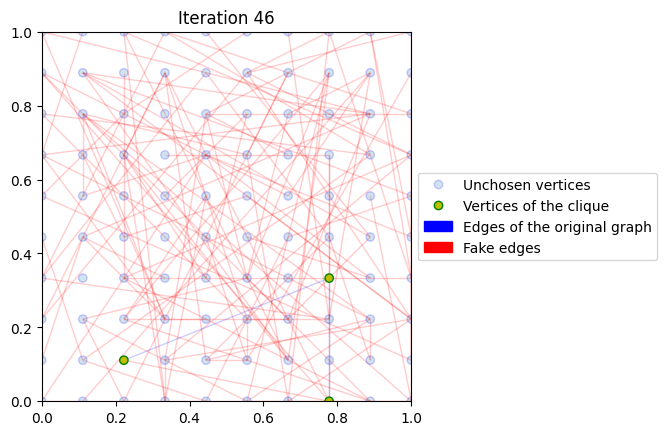

FWdc finished.


In [ ]:
x,y = FWdc(objective, gradient_fx, gradient_fy, A, Abar, n, s, k_factorial, max_iter=200, tol=1e-6, plot=True, vertex_positions=vertices)

In [ ]:
#Print the support of x
print("Support of the final solution :")
print(np.where(x != 0)[0])

print(x)

Support of the final solution :
[ 7 12 37]
[0.         0.         0.         0.         0.         0.
 0.         0.33333295 0.         0.         0.         0.
 0.33333329 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.33333376 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0

In [ ]:
print(is_clique(A + y,x,k))

True


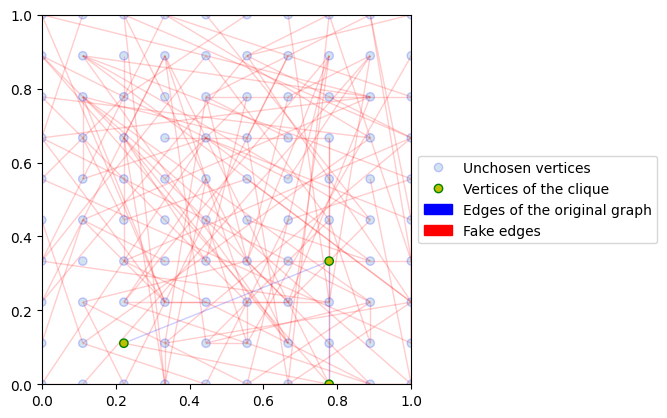

In [ ]:
plot_fake_edges_and_final_clique(A, vertices, x, y)